# I use some ideas and codes from below three articles, please check before reading this notebook
## Article 1: https://medium.com/@wolfapple/traffic-sign-recognition-2b0c3835e104
## Article 2: https://github.com/wolfapple/traffic-sign-recognition/blob/master/notebook.ipynb
## Article 3: https://towardsdatascience.com/convnets-series-spatial-transformer-networks-cff47565ae81

In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
from PIL import Image
from torchvision import transforms
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
import torchvision
import PIL
import torch.utils.data.sampler as sampler
from torch import nn
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

# Use GPU

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# In my Dataset, I resize the image to (32,32)

In [3]:
class GTSRBDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.GTSRB_frame = pd.read_csv(os.path.join(root_dir,csv_file))
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.GTSRB_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_path = os.path.join(self.root_dir, self.GTSRB_frame.iloc[idx, -1])
        img = cv2.imread(img_path)
        PIL = transforms.ToPILImage()
        img = PIL(img)
        Resize = transforms.Resize((32,32))
        img = Resize(img)
        img = np.array(img)
        if self.transform:
            img = self.transform(img)            
        label = self.GTSRB_frame.iloc[idx, -2]
        return img, label

# This function comes from Article 1 and 2. In short, it turns image to gray.

In [4]:
class CLAHE_GRAY:
    def __init__(self, clipLimit=2.5, tileGridSize=(4, 4)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, im):
        img_y = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        img_y = clahe.apply(img_y)
        img_output = img_y.reshape(img_y.shape + (1,))
        return img_output

# Data augmentation technique which comes from Article 1. Randomly apply rotation and affine to images. Note that we can't apply horizontal flip or vertical flip to images because images are traffic signs.
# What is affine: https://en.wikipedia.org/wiki/Affine_transformation

In [5]:
train_data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToPILImage(),
    transforms.RandomApply([
        transforms.RandomRotation(20, resample=PIL.Image.BICUBIC,fill=(0,)),
        transforms.RandomAffine(0, translate=(0.2, 0.2), resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, shear=20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, scale=(0.8, 1.2), resample=PIL.Image.BICUBIC)
    ]),
    transforms.ToTensor()
])
test_data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToTensor()
])

In [6]:
path = '../gtsrb-german-traffic-sign'
train_dataset = GTSRBDataset('Train.csv', path, train_data_transforms)
test_dataset = GTSRBDataset('Test.csv', path, test_data_transforms)

# Number of training data in each class. Notice that the data set is biased.

<BarContainer object of 43 artists>

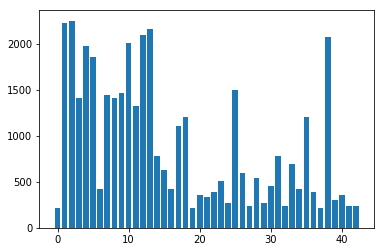

In [5]:
labels = np.array(pd.read_csv('../gtsrb-german-traffic-sign/Train.csv')['ClassId'])
class_sample_count = np.bincount(labels)
plt.bar(range(43),class_sample_count)

# Using sampler in dataloader to make sure the number of training data in each class are almost the same and by the way increase the size of training set. This idea and code come from Article 1 and 2.
# See how sampler works here: https://pytorch.org/docs/stable/_modules/torch/utils/data/sampler.html https://pytorch.org/docs/stable/data.html

In [7]:
labels = np.array(pd.read_csv('../gtsrb-german-traffic-sign/Train.csv')['ClassId'])
class_sample_count = np.bincount(labels)
weights = 1 / np.array([class_sample_count[y] for y in labels])
samp = sampler.WeightedRandomSampler(weights, 43 * 10000)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=samp)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# I implement a multiscale features neural network with a spatial tranformer network. The architecture comes from Article 3.
# Important points in this network. 
## 1. Multiscale features neural network: https://towardsdatascience.com/convnets-series-spatial-transformer-networks-cff47565ae81
## 2. Spatial tranformer network: https://towardsdatascience.com/review-stn-spatial-transformer-network-image-classification-d3cbd98a70aa https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html
## 3. Dropout and BatchNorm: https://www.coursera.org/learn/deep-neural-network?specialization=deep-learning#syllabus

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.column1 = nn.Sequential(
            nn.Conv2d(1,100,kernel_size = 7,stride=1,padding=3),
            nn.BatchNorm2d(100),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(2,2),
            nn.MaxPool2d(8,8)
        )
        
        self.column2 = nn.Sequential(
            nn.Conv2d(1,100,kernel_size = 7,stride=1,padding=3),
            nn.BatchNorm2d(100),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(2,2),
            nn.Conv2d(100,150,kernel_size = 5,stride=1,padding=2),
            nn.BatchNorm2d(150),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(2,2),
            nn.MaxPool2d(4,4)
        )
        
        self.column3 = nn.Sequential(
            nn.Conv2d(1,100,kernel_size = 7,stride=1,padding=3),
            nn.BatchNorm2d(100),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(2,2),
            nn.Conv2d(100,150,kernel_size = 5,stride=1,padding=2),
            nn.BatchNorm2d(150),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(2,2),
            nn.Conv2d(150,250,kernel_size = 5,stride=1,padding=2),
            nn.BatchNorm2d(250),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(2,2),
            nn.MaxPool2d(2,2)
        )
                        
        self.fc1 = nn.Sequential(
            nn.Linear(2000,300),
            nn.BatchNorm1d(300),
            nn.ReLU(True),
            nn.Dropout(p=0.5)
        )
        
        self.fc2 = nn.Sequential(
           nn.Linear(300,43),
           nn.BatchNorm1d(43)
        )
            
        # Spatial transformer localization-network
        self.localization1 = nn.Sequential(
            nn.MaxPool2d(2,2),
            nn.Conv2d(1,100,kernel_size = 5,stride=1,padding=2),
            nn.ReLU(True),
            nn.BatchNorm2d(100),
            nn.MaxPool2d(2,2),
            nn.MaxPool2d(4,4)
        )
        
        self.localization2 = nn.Sequential(
            nn.MaxPool2d(2,2),
            nn.Conv2d(1,100,kernel_size = 5,stride=1,padding=2),
            nn.ReLU(True),
            nn.BatchNorm2d(100),
            nn.MaxPool2d(2,2),
            nn.Conv2d(100,200,kernel_size = 5,stride=1,padding=2),
            nn.BatchNorm2d(200),
            nn.ReLU(True),
            nn.MaxPool2d(2,2),
            nn.MaxPool2d(2,2)
        )
        

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(1200, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(100, 3 * 2)
        )
        

        # Initialize the weights/bias with identity transformation
        self.fc_loc[4].weight.data.zero_()
        self.fc_loc[4].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        x1 = self.localization1(x)
        x1 = x1.view(-1, 400)
        #print(x1.shape)
        x2 = self.localization2(x)
        x2 = x2.view(-1,800)
        #print(x2.shape)
        xs = torch.cat((x1,x2),1)
        #print(xs.shape)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x1 = self.column1(x)
        x2 = self.column2(x)
        x3 = self.column3(x)
        x1 = x1.view(-1,400)
        x2 = x2.view(-1,600)
        x3 = x3.view(-1,1000)
        x = torch.cat((x1,x2,x3),1)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# I used learning rate 0.001 here. We can try learning rate decay later.

In [14]:
net = Net()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr = 0.001)

In [15]:
Loss = []
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        net.to(device)
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            Loss.append(running_loss / 100)
            running_loss = 0.0
        
print('Finished Training')

[1,   100] loss: 3.552
[1,   200] loss: 2.669
[1,   300] loss: 2.141
[1,   400] loss: 1.791
[1,   500] loss: 1.570
[1,   600] loss: 1.405
[1,   700] loss: 1.277
[1,   800] loss: 1.212
[1,   900] loss: 1.115
[1,  1000] loss: 1.005
[1,  1100] loss: 0.943
[1,  1200] loss: 0.898
[1,  1300] loss: 0.821
[1,  1400] loss: 0.815
[1,  1500] loss: 0.774
[1,  1600] loss: 0.736
[1,  1700] loss: 0.722
[1,  1800] loss: 0.690
[1,  1900] loss: 0.660
[1,  2000] loss: 0.617
[1,  2100] loss: 0.596
[1,  2200] loss: 0.601
[1,  2300] loss: 0.563
[1,  2400] loss: 0.554
[1,  2500] loss: 0.548
[1,  2600] loss: 0.518
[1,  2700] loss: 0.514
[1,  2800] loss: 0.490
[1,  2900] loss: 0.500
[1,  3000] loss: 0.478
[1,  3100] loss: 0.429
[1,  3200] loss: 0.412
[1,  3300] loss: 0.431
[1,  3400] loss: 0.406
[1,  3500] loss: 0.391
[1,  3600] loss: 0.417
[1,  3700] loss: 0.371
[1,  3800] loss: 0.381
[1,  3900] loss: 0.358
[1,  4000] loss: 0.342
[1,  4100] loss: 0.349
[1,  4200] loss: 0.333
[1,  4300] loss: 0.322
[1,  4400] 

[6,  4300] loss: 0.016
[6,  4400] loss: 0.022
[6,  4500] loss: 0.022
[6,  4600] loss: 0.018
[6,  4700] loss: 0.025
[6,  4800] loss: 0.029
[6,  4900] loss: 0.023
[6,  5000] loss: 0.022
[6,  5100] loss: 0.022
[6,  5200] loss: 0.027
[6,  5300] loss: 0.021
[6,  5400] loss: 0.023
[6,  5500] loss: 0.017
[6,  5600] loss: 0.011
[6,  5700] loss: 0.007
[6,  5800] loss: 0.010
[6,  5900] loss: 0.019
[6,  6000] loss: 0.019
[6,  6100] loss: 0.026
[6,  6200] loss: 0.018
[6,  6300] loss: 0.035
[6,  6400] loss: 0.028
[6,  6500] loss: 0.019
[6,  6600] loss: 0.024
[6,  6700] loss: 0.026
[6,  6800] loss: 0.016
[6,  6900] loss: 0.014
[6,  7000] loss: 0.013
[6,  7100] loss: 0.019
[6,  7200] loss: 0.020
[6,  7300] loss: 0.021
[6,  7400] loss: 0.014
[6,  7500] loss: 0.021
[6,  7600] loss: 0.021
[6,  7700] loss: 0.020
[6,  7800] loss: 0.027
[6,  7900] loss: 0.029
[6,  8000] loss: 0.018
[6,  8100] loss: 0.021
[6,  8200] loss: 0.019
[6,  8300] loss: 0.020
[6,  8400] loss: 0.014
[6,  8500] loss: 0.013
[6,  8600] 

# The plot of training loss

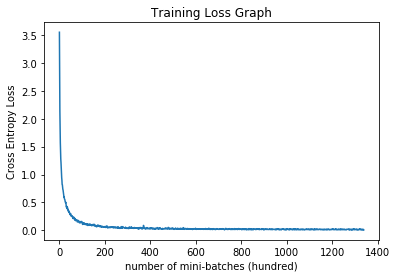

In [21]:
plt.plot(Loss)
plt.xlabel("number of mini-batches (hundred)")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Loss Graph")
plt.savefig("../GTSRB parameters/Training_Loss lr0.001 epoch10.png")

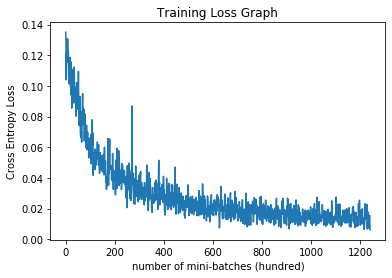

In [26]:
plt.plot(Loss[100:])
plt.xlabel("number of mini-batches (hundred)")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Loss Graph")
plt.savefig("../GTSRB parameters/Training_Loss after 100 batches lr0.001 epoch10.png")

# Save parameters

In [27]:
PATH = "../GTSRB parameters/MultiScale Net with STN (10000 samples,lr0.001,epoch10,batch32)"
torch.save(net.state_dict(), PATH)

# Load parameters

In [11]:
PATH = "../GTSRB parameters/MultiScale Net with STN (10000 samples,lr0.001,epoch10,batch32)"
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# The effect of Spatial Transformer Network

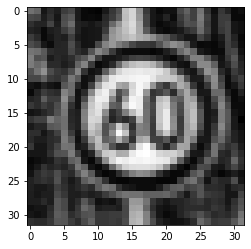

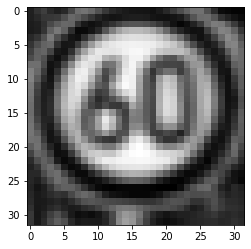

In [38]:
iter_train_loader = iter(train_loader)
image = next(iter_train_loader)
plt.imshow(image[0][0].squeeze(), cmap = "gray")
plt.show()
plt.imshow(net.stn(image[0])[0].detach().numpy().squeeze(), cmap = "gray")
plt.show()

# The Overall accuracy

In [33]:
correct = 0
total = 0
net.to(device)
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 94 %


# The accuracy of each class

In [35]:
classes = tuple(range(43))
class_correct = list(0. for i in range(43))
class_total = list(0. for i in range(43))
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(43):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 100 %
Accuracy of     1 : 96 %
Accuracy of     2 : 98 %
Accuracy of     3 : 94 %
Accuracy of     4 : 93 %
Accuracy of     5 : 93 %
Accuracy of     6 : 93 %
Accuracy of     7 : 95 %
Accuracy of     8 : 95 %
Accuracy of     9 : 98 %
Accuracy of    10 : 96 %
Accuracy of    11 : 89 %
Accuracy of    12 : 93 %
Accuracy of    13 : 96 %
Accuracy of    14 : 98 %
Accuracy of    15 : 98 %
Accuracy of    16 : 99 %
Accuracy of    17 : 98 %
Accuracy of    18 : 87 %
Accuracy of    19 : 90 %
Accuracy of    20 : 100 %
Accuracy of    21 : 97 %
Accuracy of    22 : 97 %
Accuracy of    23 : 96 %
Accuracy of    24 : 97 %
Accuracy of    25 : 92 %
Accuracy of    26 : 96 %
Accuracy of    27 : 73 %
Accuracy of    28 : 98 %
Accuracy of    29 : 98 %
Accuracy of    30 : 82 %
Accuracy of    31 : 93 %
Accuracy of    32 : 100 %
Accuracy of    33 : 94 %
Accuracy of    34 : 100 %
Accuracy of    35 : 93 %
Accuracy of    36 : 96 %
Accuracy of    37 : 90 %
Accuracy of    38 : 93 %
Accuracy of    39 : 9